# Project-BipedalWalker-Hardcore

## Bipedal Walker Hardcore Problem

"BipedalWalkerHardcore-v3" task is an advanced version of "BipedalWalker-v3" with ladders, stumps, and pitfalls. 

The state and action space are exactly the same as "BipedalWalker-v3".

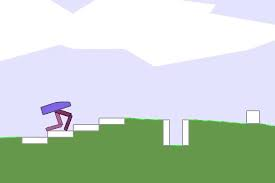


### Formulation

- *State* $s$: 
The state consists of 24 observations as follows:

Num   | Observation                |  Min   |   Max  | Mean
------|----------------------------|--------|--------|------   
0     | hull_angle                 |  0     | 2$\pi$ |  0.5
1     | hull_angularVelocity       |  -inf  |  +inf  |  -
2     | vel_x                      |  -1    |  +1    |  -
3     |  vel_y                     |  -1    |  +1    |  -
4     | hip_joint_1_angle          |  -inf  |  +inf  |  -
5     | hip_joint_1_speed          |  -inf  |  +inf  |  -
6     | knee_joint_1_angle         |  -inf  |  +inf  |  -
7     | knee_joint_1_speed         |  -inf  |  +inf  |  -
8     | leg_1_ground_contact_flag  |  0     |  1     |  -
9     | hip_joint_2_angle          |  -inf  |  +inf  |  -
10    | hip_joint_2_speed          |  -inf  |  +inf  |  -
11    | knee_joint_2_angle         |  -inf  |  +inf  |  -
12    | knee_joint_2_speed         |  -inf  |  +inf  |  -
13    | leg_2_ground_contact_flag  |  0     |  1     |  -
14-23 | 10 lidar readings          |  -inf  |  +inf  |  -


- *Action $a$*:
The continuous action has four dimensions:

Num | Name                        | Min  | Max  
----|-----------------------------|------|------
0   | Hip_1 (Torque / Velocity)   |  -1  | +1
1   | Knee_1 (Torque / Velocity)  |  -1  | +1
2   | Hip_2 (Torque / Velocity)   |  -1  | +1
3   | Knee_2 (Torque / Velocity)  |  -1  | +1


- *Reward $r(s,a)$*:
    
    Reward is given for moving forward, the walker can get 300+ points when reaching the far end. If the walker falls, it gets -100.
    

- Episode Termination

    An episode terminates when one of the following occurs:
  - The walker reaches the far right side of the environment.
  - The walker touches the ground.
  - Episode length is greater than 1600.



- *Objective*:
    To get an average reward as more as possible over 30 consecutive trials (episodes).


In [1]:
# Import packages. Run this cell.
!pip install Box2D
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random
import torch.optim as optim
import copy

/miniconda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Task
(100 points)

You are allowed to solve the "BipedalWalkerHardcore-v3" using any algorithms as long as you could get a satisfied reward.

You can also complete the function ``learn_and_update_weights_by_replay(self,training_iterations, weight, totrain):`` to implement the algorithm TD3-FORK which can solve the task successfully. In particular, you need to complement 
- Training system netwrok. (mapping from [s,a] to [s'])
- Training Actor. (mapping form [s] to [a])

The details can be found in this paper [Paper](https://arxiv.org/pdf/2010.01652.pdf).

### Requirement

- After training your algorithm, please save your well trained agent as ``agent.py``, upload ``agent.py`` and related files to Gradescope. We will test your policy (actor) for 30 episodes on Gradescope. 

- Do not modify the function ``select_action(self, state)`` in the class ``Agent`` which is used for testing your policy.

(We will provide a sample agent in the following section.)


**Note**: 
- Do not try to use a large ``Actor`` network, 2048 * 2048 is large enough and 256 * 256 is sufficient. Large network will eat a lot of running time and remind that the running time limit is $30$ minutes.

- You can use GPU to accelerate the training, but make sure that the actor network you saved is on CPU.

- We also provide some training tricks in the following section.

In [2]:
"""
A sample agent 
"""

# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import random
# import gym
# import os
# import time


# # Actor Neural Network
# class Actor(nn.Module):
#     # def __init__(self, state_size, action_size, seed, fc_units=256, fc1_units=256):
#     def __init__(self, state_size, action_size, seed, fc_units=1024, fc1_units=1024):
#         super(Actor, self).__init__()
#         self.seed = torch.manual_seed(seed)
#         self.fc1 = nn.Linear(state_size, fc_units)
#         self.fc2 = nn.Linear(fc_units, fc1_units)
#         self.fc3 = nn.Linear(fc1_units, action_size)

#     def forward(self, state):
#         """Build an actor (policy) network that maps states -> actions."""
#         x = F.relu(self.fc1(state))
#         x = F.relu(self.fc2(x))
#         return F.torch.tanh(self.fc3(x))

# # Agent Class
# class Agent:
#     def __init__(
#         self,
#         gamma = 0.99, #discount factor
#         lr_actor = 3e-4,
#         lr_critic = 3e-4):
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.env = gym.make('BipedalWalkerHardcore-v3')
#         self.create_actor()

#     def create_actor(self):
#         params = {
#             'state_size':      self.env.observation_space.shape[0],
#             'action_size':     self.env.action_space.shape[0],
#             'seed':            88
#         }
#         self.actor = Actor(**params).to(self.device)
#         self.actor.load_state_dict(torch.load('actor.pth', map_location=torch.device('cpu'))) #a pre saved model

#     def select_action(self,state):
#         state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
#         self.actor.eval()
#         with torch.no_grad():
#             actions = self.actor(state).cpu().data.numpy()
#         return np.squeeze(actions)


In [3]:
"""
In the following section, we provide the main construct the agent by using the algorithm TD3-FORK.
"""

'\nIn the following section, we provide the main construct the agent by using the algorithm TD3-FORK.\n'

In [2]:
# Actor Neural Network
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc_units=400, fc1_units=300):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc1_units)
        self.fc3 = nn.Linear(fc1_units, action_size)

    def forward(self, state):
        """
        Build an actor (policy) network that maps states -> actions.
        Args:
            state: torch.Tensor with shape (batch_size, state_size)
        Returns:
            action: torch.Tensor with shape (batch_size, action_size)
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.torch.tanh(self.fc3(x))

# Q1-Q2-Critic Neural Network  
  
class Critic(nn.Module):
    """
    Args:
        state_size: state dimension
        action_size: action dimension
        fc_units: number of neurons in one fully connected hidden layer
    """
    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        # Q1 architecture
        self.l1 = nn.Linear(state_size + action_size, fc1_units)
        self.l2 = nn.Linear(fc1_units, fc2_units)
        self.l3 = nn.Linear(fc2_units, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_size + action_size, fc1_units)
        self.l5 = nn.Linear(fc1_units, fc2_units)
        self.l6 = nn.Linear(fc2_units, 1)

    def forward(self, state, action):
        """
        Build a critic (value) network that maps state-action pairs -> Q-values.
        Args:
            state: torch.Tensor with shape (batch_size, state_size)
            action: torch.Tensor with shape (batch_size, action_size)
        Returns:
            x_1: torch.Tensor with shape (batch_size, 1)
            x_2: torch.Tensor with shape (batch_size, 1)
        """
        xa = torch.cat([state, action], 1)

        x1 = F.relu(self.l1(xa))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        x2 = F.relu(self.l4(xa))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)

        return x1, x2
    
    def Q1(self, state, action):
        xa = torch.cat([state, action], 1)
        x1 = F.relu(self.l1(xa))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)
        return x1

class Sys_R(nn.Module):
    def __init__(self,state_size, action_size, fc1_units=256, fc2_units=256):
        super(Sys_R, self).__init__()

        self.l1 = nn.Linear(2 * state_size + action_size, fc1_units)
        self.l2 = nn.Linear(fc1_units,fc2_units)
        self.l3 = nn.Linear(fc2_units, 1)


    def forward(self, state, next_state, action):
        xa = torch.cat([state, next_state, action], 1)

        x1 = F.relu(self.l1(xa))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)
        return x1

class SysModel(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=400, fc2_units=300):
        super(SysModel, self).__init__()
        self.l1 = nn.Linear(state_size + action_size, fc1_units)
        self.l2 = nn.Linear(fc1_units, fc2_units)
        self.l3 = nn.Linear(fc2_units, state_size)


    def forward(self, state, action):
        """Build a system model to predict the next state at given state and action.
        Returns:
            state: torch.Tensor with shape (batch_size, state_size)
        """
        xa = torch.cat([state, action], 1)

        x1 = F.relu(self.l1(xa))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        return x1

"""
TD3_FORK AGENT
"""

class Agent:
    def __init__(
        self,
        load = False,
        gamma = 0.99, #discount factor
        lr_actor = 3e-4,  # learning rate for actor network
        lr_critic = 3e-4, # learning rate for critic network
        lr_sysmodel = 3e-4, # learning rate for system network
        lr_sysr = 3e-4, # learning rate for the system reward
        batch_size = 100,  # mini-batch size
        buffer_capacity = 1000000, # reply buffer capacitty
        tau = 0.02,  #target network update factor
        random_seed = np.random.randint(1,10000),  #random seed
        policy_noise=0.2,   # noise added to actor
        std_noise = 0.1,    # standard deviation for smoothing noise added to target policy
        noise_clip=0.5,   #noise bound
        policy_freq=2, #target network update period
        sys_weight=0.5
    ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.env = gym.make('BipedalWalkerHardcore-v3')
        self.create_actor()
        self.create_critic()
        self.create_sysmodel()
        self.create_sysr()
        self.act_opt = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.crt_opt = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.sys_opt = optim.Adam(self.sysmodel.parameters(), lr=lr_sysmodel) #define system model
        self.sysr_opt = optim.Adam(self.sysr.parameters(), lr=lr_sysr)
        self.set_weights()
        self.replay_memory_buffer = deque(maxlen = buffer_capacity)
        self.replay_memory_bufferd_dis = deque(maxlen = buffer_capacity)
        self.batch_size = batch_size
        self.tau = tau
        self.policy_freq = policy_freq
        self.gamma = gamma
        self.upper_bound = self.env.action_space.high[0] #action space upper bound
        self.lower_bound = self.env.action_space.low[0]  #action space lower bound
        self.obs_upper_bound = self.env.observation_space.high[0] #state space upper bound
        self.obs_lower_bound = self.env.observation_space.low[0]  #state space lower bound
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.std_noise = std_noise
        self.sys_weight = sys_weight
 

    def create_actor(self):
        params = {
            'state_size':      self.env.observation_space.shape[0],
            'action_size':     self.env.action_space.shape[0],
            'seed':            88
        }
        self.actor = Actor(**params).to(self.device)
        self.actor_target = Actor(**params).to(self.device)

    # def create_actor(self):
    #     params = {
    #         'state_size':      self.env.observation_space.shape[0],
    #         'action_size':     self.env.action_space.shape[0],
    #         'seed':            88
    #     }
    #     self.actor = Actor(**params).to(self.device)
    #     self.actor.load_state_dict(torch.load('actor.pth', map_location=torch.device('cpu'))) #a pre saved model
        # self.actor_target = Actor(**params).to(self.device)
        # self.actor_target.load_state_dict(torch.load('actor.pth', map_location=torch.device('cpu'))) #a pre saved model
    
    def create_critic(self):
        params = {
            'state_size':      self.env.observation_space.shape[0],
            'action_size':     self.env.action_space.shape[0],
            'seed':            88
        }
        self.critic = Critic(**params).to(self.device)
        self.critic_target = Critic(**params).to(self.device)

    def create_sysmodel(self):
        params = {
            'state_size':      self.env.observation_space.shape[0],
            'action_size':     self.env.action_space.shape[0]
        }
        self.sysmodel = SysModel(**params).to(self.device)
    
    def create_sysr(self):
        params = {
            'state_size':     self.env.observation_space.shape[0],
            'action_size':    self.env.action_space.shape[0]
        }
        self.sysr = Sys_R(**params).to(self.device)
            
    def set_weights(self):
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())


    def add_to_replay_memory(self, transition, buffername):
        #add samples to replay memory
        buffername.append(transition)

    def get_random_sample_from_replay_mem(self, buffername):
        #random samples from replay memory
        random_sample = random.sample(buffername, self.batch_size)
        return random_sample


    def learn_and_update_weights_by_replay(self, training_iterations, weight, totrain):
        """Update policy and value parameters using given batch of experience tuples.
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        weight is used for training  actor
        To train indicates whether we will train actor or not. We may not need to train Actor when the performance is good enough.
        This is a placeholder, you can define your criteria.
        """
        if len(self.replay_memory_buffer) < 1e4:
            return 1
        for it in range(training_iterations):
            mini_batch = self.get_random_sample_from_replay_mem(self.replay_memory_buffer)
            state_batch = torch.from_numpy(np.vstack([i[0] for i in mini_batch])).float().to(self.device)
            action_batch = torch.from_numpy(np.vstack([i[1] for i in mini_batch])).float().to(self.device)
            reward_batch = torch.from_numpy(np.vstack([i[2] for i in mini_batch])).float().to(self.device)
            next_state_batch = torch.from_numpy(np.vstack([i[3] for i in mini_batch])).float().to(self.device)
            done_list = torch.from_numpy(np.vstack([i[4] for i in mini_batch]).astype(np.uint8)).float().to(self.device)

            # Training and updating Actor & Critic networks.
            
            #Train Critic
            target_actions = self.actor_target(next_state_batch)
            offset_noises = torch.FloatTensor(action_batch.shape).data.normal_(0, self.policy_noise).to(self.device)

            #clip noise
            offset_noises = offset_noises.clamp(-self.noise_clip, self.noise_clip)
            target_actions = (target_actions + offset_noises).clamp(self.lower_bound, self.upper_bound)

            #Compute the target Q value
            Q_targets1, Q_targets2 = self.critic_target(next_state_batch, target_actions)
            Q_targets = torch.min(Q_targets1, Q_targets2)
            Q_targets = reward_batch + self.gamma * Q_targets * (1 - done_list)

            #Compute current Q estimates
            current_Q1, current_Q2 = self.critic(state_batch, action_batch)
            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, Q_targets.detach()) + F.mse_loss(current_Q2, Q_targets.detach())
            # Optimize the critic
            self.crt_opt.zero_grad()
            critic_loss.backward()
            self.crt_opt.step()

            # self.soft_update_target(self.critic, self.critic_target)


            """Train Sysmodel"""       
            next_state_prediction = self.sysmodel(state_batch, action_batch)
            next_state_prediction = next_state_prediction.clamp(self.obs_lower_bound, self.obs_upper_bound)
            sysmodel_loss = F.smooth_l1_loss(next_state_prediction, next_state_batch.detach())
            
            self.sys_opt.zero_grad()
            sysmodel_loss.backward()
            self.sys_opt.step()
            self.sysmodel_loss = sysmodel_loss.item()
            
            reward_prediction = self.sysr(state_batch, next_state_batch, action_batch)
            sysr_loss = F.mse_loss(reward_prediction, reward_batch.detach())
            self.sysr_opt.zero_grad()
            sysr_loss.backward()
            self.sysr_opt.step()
            self.sysr_loss = sysr_loss.item()
            
            s_flag = 1 if sysmodel_loss.item() < 0.010 else 0
            
            if it % self.policy_freq == 0:
                
                actor_loss1 = -self.critic.Q1(state_batch, self.actor(state_batch)).mean()
                
                if s_flag == 1:
                    p_next_state = self.sysmodel(state_batch, self.actor(state_batch))
                    p_next_state = p_next_state.clamp(self.obs_lower_bound,self.obs_upper_bound)
                    actions2 = self.actor(p_next_state.detach())
                    p_next_r = self.sysr(state_batch, p_next_state.detach(), self.actor(state_batch))

                    p_next_state2 = self.sysmodel(p_next_state, self.actor(p_next_state.detach()))
                    p_next_state2 = p_next_state2.clamp(self.obs_lower_bound, self.obs_upper_bound)
                    p_next_r2 = self.sysr(p_next_state.detach(), p_next_state2.detach(), self.actor(p_next_state.detach()))
                    actions3 = self.actor(p_next_state2.detach())

                    actor_loss2 =  self.critic.Q1(p_next_state2.detach(), actions3)
                    actor_loss3 =  -(p_next_r + self.gamma * p_next_r2 + self.gamma ** 2 * actor_loss2).mean()
                    actor_loss = (actor_loss1 + self.sys_weight * actor_loss3)
                else:
                    actor_loss = actor_loss1
                
                self.crt_opt.zero_grad()
                self.sys_opt.zero_grad()
                self.act_opt.zero_grad()
                actor_loss.backward()
                self.act_opt.step()
                
                # Update the frozen target models
                self.soft_update_target(self.critic, self.critic_target)
                self.soft_update_target(self.actor, self.actor_target)                
            
                

    def soft_update_target(self,local_model,target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

    def policy(self,state):
        """select action based on ACTOR but with noise added"""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.actor.eval()
        with torch.no_grad():
            actions = self.actor(state).cpu().data.numpy()
        self.actor.train()
        # Adding noise to action
        shift_action = np.random.normal(0, self.std_noise, size=self.env.action_space.shape[0])
        sampled_actions = (actions + shift_action)
        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions,self.lower_bound,self.upper_bound)
        return np.squeeze(legal_action)


    def select_action(self,state):
        """select action based on ACTOR"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        with torch.no_grad():
            actions = self.actor_target(state).cpu().data.numpy()
        return np.squeeze(actions)

    def save(self, filename):
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.crt_opt.state_dict(), filename + "_critic_optimizer")

        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.act_opt.state_dict(), filename + "_actor_optimizer")

        torch.save(self.sysmodel.state_dict(), filename + "_sysmodel")
        torch.save(self.sys_opt.state_dict(), filename + "_sysmodel_optimizer")

        torch.save(self.sysr.state_dict(), filename + "_reward_model")
        torch.save(self.sysr_opt.state_dict(), filename + "_reward_model_optimizer")
        
        torch.save(self.replay_memory_buffer, filename + "_replay_memory_buffer")
        torch.save(self.replay_memory_bufferd_dis, filename + "_replay_memory_bufferd_dis")

    def load(self, filename):
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.crt_opt.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.critic_target.load_state_dict(torch.load(filename + "_critic"))

        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.act_opt.load_state_dict(torch.load(filename + "_actor_optimizer"))
        self.actor_target.load_state_dict(torch.load(filename + "_actor"))

        self.sysmodel.load_state_dict(torch.load(filename + "_sysmodel"))
        self.sys_opt.load_state_dict(torch.load(filename + "_sysmodel_optimizer"))

        self.sysr.load_state_dict(torch.load(filename + "_reward_model"))
        self.sysr_opt.load_state_dict(torch.load(filename + "_reward_model_optimizer"))
        
        # self.replay_memory_buffer = torch.load(filename + "_replay_memory_buffer")
        # self.replay_memory_bufferd_dis = torch.load(filename + "replay_memory_bufferd_dis")

In [3]:
import time
"""
Training Agent and some Training Tricks
"""
gym.logger.set_level(40)
max_steps = 3000
falling_down = 0
base_weight = .6


if __name__ == '__main__':
    env = gym.make('BipedalWalkerHardcore-v3')
    agent = Agent(batch_size = 100) #Use TD3 for example
    total_episodes = 100000
    start_timestep=0            #time_step to select action based on Actor
    time_start = time.time()        # Init start time
    ep_reward_list = []
    avg_reward_list = []
    total_timesteps = 0
    save_time = 0
    expcount = 0
    totrain = 0
    avg_reward_max = -9000000

    for ep in range(total_episodes):
        state = env.reset()
        episodic_reward = 0
        timestep = 0
        temp_replay_buffer = []
        for st in range(max_steps):
            # Select action randomly or according to policy
            if total_timesteps < start_timestep:
                action = env.action_space.sample()
            else:
                action = agent.policy(state)
            # Recieve state and reward from environment.
            next_state, reward, done, info = env.step(action)
            #change original reward from -100 to -5 and 5*reward for other values
            episodic_reward += reward
            if reward == -100:
                add_reward = -1
                reward = -5
                falling_down += 1 #check whether the bipedal falls down or not
                expcount += 1
            else:
                add_reward = 0
                reward = 5 * reward

            temp_replay_buffer.append((state, action, reward, next_state, done))
            
            # End this episode when `done` is True
            # We add few samples to replay buffer when episodic reward is higher.
            if done:
                agent.sys_weight =  np.round((1 - np.clip(np.mean(ep_reward_list[-100:])/320, 0, 1)),4) * base_weight
                if add_reward == -1 or episodic_reward < 250:            
                    totrain = 1
                    for temp in temp_replay_buffer: 
                        agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
                elif expcount > 0 and np.random.rand() > 0.5:  
                    totrain = 1
                    expcount -= 10
                    for temp in temp_replay_buffer: 
                        agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
                break
            state = next_state
            timestep += 1     
            total_timesteps += 1
        
        ep_reward_list.append(episodic_reward)
        # Mean of last 100 episodes
        avg_reward = np.mean(ep_reward_list[-100:])
        avg_reward_list.append(avg_reward)
        s = (int)(time.time() - time_start)
        new_avg_reward_max = np.max([avg_reward, avg_reward_max])
        if new_avg_reward_max > avg_reward_max and new_avg_reward_max > 290:
            actor_path = "actors/actor_%s.pth" % str(round(new_avg_reward_max))
            torch.save(agent.actor.to("cpu").state_dict(), actor_path)
            agent.actor.to("cuda")
        avg_reward_max = new_avg_reward_max

        #Training agent only when new experiences are added to the replay buffer
        #If totrain == 1 we update actor network else we only update critic network
        weight =  1 - np.clip(np.mean(ep_reward_list[-100:])/300, 0, 1) #weight for FORK actor
        if totrain == 1:
            agent.learn_and_update_weights_by_replay(timestep, weight, totrain)
        else: 
            agent.learn_and_update_weights_by_replay(100, weight, totrain)
        totrain = 0

        print('Ep. {}, Timestep {},  Ep.Timesteps {}, Episode Reward: {:.2f}, Moving Avg.Reward: {:.2f}, Max Avg.Reward: {:.2f}, Time: {:02}:{:02}:{:02}'.format(ep, total_timesteps, timestep,
                      episodic_reward, avg_reward, avg_reward_max, s//3600, s%3600//60, s%60)) 
    
        if ep % 100 == 0 and ep != 0:
            filename = "checkpoint/checkpoint"
            actor_path = "checkpoint/actor_cpu_%s.pth" % str(round(avg_reward_max))
            torch.save(agent.actor.to("cpu").state_dict(), actor_path)
            agent.actor.to("cuda")
            agent.save(filename)

/miniconda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/miniconda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ep. 0, Timestep 76,  Ep.Timesteps 76, Episode Reward: -93.89, Moving Avg.Reward: -93.89, Max Avg.Reward: -93.89, Time: 00:00:00
Ep. 1, Timestep 191,  Ep.Timesteps 115, Episode Reward: -92.76, Moving Avg.Reward: -93.33, Max Avg.Reward: -93.33, Time: 00:00:00
Ep. 2, Timestep 270,  Ep.Timesteps 79, Episode Reward: -93.85, Moving Avg.Reward: -93.50, Max Avg.Reward: -93.33, Time: 00:00:00
Ep. 3, Timestep 359,  Ep.Timesteps 89, Episode Reward: -93.20, Moving Avg.Reward: -93.43, Max Avg.Reward: -93.33, Time: 00:00:00
Ep. 4, Timestep 458,  Ep.Timesteps 99, Episode Reward: -92.70, Moving Avg.Reward: -93.28, Max Avg.Reward: -93.28, Time: 00:00:00
Ep. 5, Timestep 549,  Ep.Timesteps 91, Episode Reward: -93.30, Moving Avg.Reward: -93.28, Max Avg.Reward: -93.28, Time: 00:00:00
Ep. 6, Timestep 640,  Ep.Timesteps 91, Episode Reward: -92.94, Moving Avg.Reward: -93.24, Max Avg.Reward: -93.24, Time: 00:00:00
Ep. 7, Timestep 723,  Ep.Timesteps 83, Episode Reward: -94.16, Moving Avg.Reward: -93.35, Max Avg

KeyboardInterrupt: 

In [ ]:
# The following code is provided for testing your agent in the 'BipedalWalkerHardcore-v3' gym environment.
# gym.logger.set_level(40)
# env = gym.make('BipedalWalkerHardcore-v3')
# _ = env.reset()
# env.seed(0)
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

# timesteps_count = 0  # Counting the time steps
# max_steps = 1600  # Maximum time steps for one episode
# ep_reward_list = deque(maxlen=50)
# avg_reward = -9999
# agent = Agent()

# for ep in range(600):

#     state = env.reset()
#     episodic_reward = 0
#     timestep_for_cur_episode = 0

#     for st in range(max_steps):
#         # Select action according to policy
#         action = agent.select_action(state)
#         # Recieve state and reward from environment.
#         next_state, reward, done, info = env.step(action)
#         episodic_reward += reward
        
#         # Send the experience to the agent and train the agent
#         agent.train(timesteps_count, timestep_for_cur_episode, state, action, reward, next_state, done)
        
#         timestep_for_cur_episode += 1     
#         timesteps_count += 1
        
#         # End this episode when `done` is True
#         if done:
#             break
#         state = next_state

#     ep_reward_list.append(episodic_reward)
#     print('Ep. {}, Ep.Timesteps {}, Episode Reward: {:.2f}'.format(ep + 1, timestep_for_cur_episode, episodic_reward), end='')
    
#     if len(ep_reward_list) == 50:
#         # Mean of last 50 episodes
#         avg_reward = sum(ep_reward_list) / 50
#         print(', Moving Average Reward: {:.2f}'.format(avg_reward))
#     else:
#         print('')

# print('Average reward over 50 episodes: ', avg_reward)
# env.close()

In [11]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Save the actor
actor_path = "actor.pth"
torch.save(agent.actor.to("cpu").state_dict(), actor_path)

In [10]:
# import time
# """
# Training Agent and some Training Tricks
# """
# gym.logger.set_level(40)
# max_steps = 3000
# falling_down = 0
# base_weight = .6


# if __name__ == '__main__':
#     env = gym.make('BipedalWalkerHardcore-v3')
#     agent = Agent(batch_size = 100) #Use TD3 for example
#     agent.load('checkpoint')
#     total_episodes = 10000
#     start_timestep=0            #time_step to select action based on Actor
#     time_start = time.time()        # Init start time
#     ep_reward_list = []
#     avg_reward_list = []
#     total_timesteps = 0
#     save_time = 0
#     expcount = 0
#     totrain = 0
#     avg_reward_max = -9000000

#     for ep in range(total_episodes):
#         state = env.reset()
#         episodic_reward = 0
#         timestep = 0
#         temp_replay_buffer = []
#         for st in range(max_steps):
#             # Select action randomly or according to policy
#             if total_timesteps < start_timestep:
#                 action = env.action_space.sample()
#             else:
#                 action = agent.policy(state)
#             # Recieve state and reward from environment.
#             next_state, reward, done, info = env.step(action)
#             #change original reward from -100 to -5 and 5*reward for other values
#             episodic_reward += reward
#             if reward == -100:
#                 add_reward = -1
#                 reward = -5
#                 falling_down += 1 #check whether the bipedal falls down or not
#                 expcount += 1
#             else:
#                 add_reward = 0
#                 reward = 5 * reward

#             temp_replay_buffer.append((state, action, reward, next_state, done))
            
#             # End this episode when `done` is True
#             # We add few samples to replay buffer when episodic reward is higher.
#             if done:
#                 agent.sys_weight =  np.round((1 - np.clip(np.mean(ep_reward_list[-100:])/320, 0, 1)),4) * base_weight
#                 if add_reward == -1 or episodic_reward < 250:            
#                     totrain = 1
#                     for temp in temp_replay_buffer: 
#                         agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
#                 elif expcount > 0 and np.random.rand() > 0.5:  
#                     totrain = 1
#                     expcount -= 10
#                     for temp in temp_replay_buffer: 
#                         agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
#                 break
#             state = next_state
#             timestep += 1     
#             total_timesteps += 1
        
#         ep_reward_list.append(episodic_reward)
#         # Mean of last 100 episodes
#         avg_reward = np.mean(ep_reward_list[-100:])
#         avg_reward_list.append(avg_reward)
#         s = (int)(time.time() - time_start)
#         avg_reward_max = np.max([avg_reward, avg_reward_max])

#         #Training agent only when new experiences are added to the replay buffer
#         #If totrain == 1 we update actor network else we only update critic network
#         weight =  1 - np.clip(np.mean(ep_reward_list[-100:])/300, 0, 1) #weight for FORK actor
#         if totrain == 1:
#             agent.learn_and_update_weights_by_replay(timestep, weight, totrain)
#         else: 
#             agent.learn_and_update_weights_by_replay(100, weight, totrain)
#         totrain = 0

#         print('Ep. {}, Timestep {},  Ep.Timesteps {}, Episode Reward: {:.2f}, Moving Avg.Reward: {:.2f}, Max Avg.Reward: {:.2f}, Time: {:02}:{:02}:{:02}'.format(ep, total_timesteps, timestep,
#                       episodic_reward, avg_reward, avg_reward_max, s//3600, s%3600//60, s%60)) 
    
#         if ep % 100 == 0 and ep != 0:
#             filename = "checkpoint"
#             agent.save(filename)
            
#         if avg_reward > 318:
#             break

Ep. 0, Timestep 903,  Ep.Timesteps 903, Episode Reward: 313.04, Moving Avg.Reward: 313.04, Max Avg.Reward: 313.04, Time: 00:00:00
Ep. 1, Timestep 1405,  Ep.Timesteps 502, Episode Reward: 59.80, Moving Avg.Reward: 186.42, Max Avg.Reward: 313.04, Time: 00:00:01
Ep. 2, Timestep 2252,  Ep.Timesteps 847, Episode Reward: 317.01, Moving Avg.Reward: 229.95, Max Avg.Reward: 313.04, Time: 00:00:01
Ep. 3, Timestep 2691,  Ep.Timesteps 439, Episode Reward: 32.46, Moving Avg.Reward: 180.58, Max Avg.Reward: 313.04, Time: 00:00:02
Ep. 4, Timestep 3578,  Ep.Timesteps 887, Episode Reward: 313.16, Moving Avg.Reward: 207.09, Max Avg.Reward: 313.04, Time: 00:00:02
Ep. 5, Timestep 4465,  Ep.Timesteps 887, Episode Reward: 316.10, Moving Avg.Reward: 225.26, Max Avg.Reward: 313.04, Time: 00:00:03
Ep. 6, Timestep 5336,  Ep.Timesteps 871, Episode Reward: 315.70, Moving Avg.Reward: 238.18, Max Avg.Reward: 313.04, Time: 00:00:04
Ep. 7, Timestep 6195,  Ep.Timesteps 859, Episode Reward: 315.63, Moving Avg.Reward: 24

KeyboardInterrupt: 